In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

from matplotlib import pyplot
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.cluster import KMeans

In [2]:
## Data Import and Cleaning

In [3]:
## GLA Trees

trees = pd.read_csv(
    "london_street_trees_gla_20180214.csv",
    dtype = {
        "gla_id": str,
        "borough": str,
        "species_name": str,
        "common_name": str,
        "display_name": str,
        "load_date": str,
        "easting": float,
        "northing": float,
        "longitude": float,
        "latitude": float
    },
    encoding = "latin1"
  )

# GLA helpfully didn't tell us what coordinate projection they used
# so we might as well delete easting/northing and do all work in lon/lat
trees.drop(["easting", "northing"], axis = "columns", inplace = True);

# There are NaN values in species_name and common_name; replace with blank strings
# for ease of recoding later.
trees.fillna("", inplace = True)

# Sort out fiasco with Chestnut/Horse Chestnut mislabelling
def classify_tree_type(row):
    species = row["species_name"].lower()
    common = row["common_name"].lower()
    display = row["display_name"].lower()
    
    is_horse_chestnut = (species.find("hippocastanum") > -1) or (common.find("horse") > -1)
    is_otherwise_chestnut = (display.find("chestnut") > -1) and not is_horse_chestnut
    if is_horse_chestnut:
        return "Horse Chestnut"
    elif is_otherwise_chestnut:
        return "Chestnut"
    else:
        return row["display_name"]

trees["tree_type"] = trees.apply(classify_tree_type, axis = 1)

# Relabel borough names to conform with output areas dataset
# note the space at the end of "Barking "
trees["borough"] = trees["borough"].replace({"Barking ": "Barking and Dagenham", "Richmond": "Richmond upon Thames"})

# Keep final columns needed for analysis: id, borough, load_date, tree_type, longitude, latitude
trees.drop(["display_name", "species_name", "common_name"], axis = "columns", inplace = True)

# Transform lat/lon into shapely.Point format and transform DataFrame -> GeoDataFrame
trees.drop(["longitude", "latitude"], axis = "columns")
trees = gpd.GeoDataFrame(trees, crs = "EPSG:4326", geometry = [Point(coords) for coords in zip(trees.longitude, trees.latitude)])

In [4]:
## Residential Density by 2001 Census Output Area
#
# Density has been pre-coded into deciles to match the methodology of the walkability scores.
# We can essentially assume that walkability_score = residential_dwelling_density + other_score
# and thereby split model scores into two components:
#   1. residential density
#   2. 'street connectivity' + 'land use mix'

residential_density_deciles = pd.read_csv("residential_density.csv").loc[:, ["oa_2001", "oa_occupied_household_space_count", "residential_density", "residential_density_decile"]]

In [5]:
## Walkability Scores by 2001 Census Output Area

walkability_scores = pd.read_csv("walkability_scores.csv")

# get rid of some 'technical' area label columns
walkability_scores.drop(
    ["oa_02_2001", "casward_00_2001", "casward_02_2001", "la_00_2001", "la_02_2001"],
    axis = "columns",
    inplace = True
)

walkability_scores["Inner_London"] = walkability_scores["Inner_London"].map(lambda x: bool(x))

# select only the columns relevant for analysis
walkability_scores = walkability_scores.loc[:, ["oa_00_2001", "casward_name_2001", "laname_2001", "Inner_London", "OA_M1_raw", "OA_M2_raw", "OA_M3_raw"]]
walkability_scores = walkability_scores.rename(
    {
        "oa_00_2001": "oa_2001",
        "casward_name_2001": "ward_2001",
        "laname_2001": "local_authority_2001",
        "Inner_London": "is_inner_london",
        "OA_M1_raw": "walkability_score_m1",
        "OA_M2_raw": "walkability_score_m2",
        "OA_M3_raw": "walkability_score_m3"
    },
    axis = "columns"
)

## WARNING: extremely dodgy methodology ahead
# mix in residential dwelling_density and calculate reverse-engineered partial walkability scores
walkability_scores = walkability_scores.merge(residential_density_deciles, "left")
walkability_scores["partial_walkability_score_m1"] = walkability_scores["walkability_score_m1"] - walkability_scores["residential_density_decile"]
walkability_scores["partial_walkability_score_m2"] = walkability_scores["walkability_score_m2"] - walkability_scores["residential_density_decile"]
walkability_scores["partial_walkability_score_m3"] = walkability_scores["walkability_score_m3"] - walkability_scores["residential_density_decile"]

# adjust reverse engineered scores to range from 2-20
walkability_scores["partial_walkability_score_m1"] = pd.qcut(walkability_scores["partial_walkability_score_m1"], 21, labels = [x+2 for x in range(19)], duplicates = "drop").astype(int)
walkability_scores["partial_walkability_score_m2"] = pd.qcut(walkability_scores["partial_walkability_score_m2"], 22, labels = [x+2 for x in range(19)], duplicates = "drop").astype(int)
walkability_scores["partial_walkability_score_m3"] = pd.qcut(walkability_scores["partial_walkability_score_m3"], 23, labels = [x+2 for x in range(19)], duplicates = "drop").astype(int)
## WARNING ENDS: no more dodgy methodology from hereon out.
## Note, though: walkability score can no longer be recovered by adding partial_walkability_score + residential_density_decile

In [6]:
## 2001 Census Output Areas

output_areas = gpd.read_file("england_oa_2001.shp")

## Add Walkability Scores to Census Output Areas
output_areas = output_areas.merge(
    walkability_scores,
    "inner",
    left_on = "ons_label",
    right_on = "oa_2001"
)

# git rid of always-blank 'name' column
output_areas.drop(["name"], axis = "columns", inplace = True)

# split into three GeoDataFrames containing: polygons (and area), centroids, and population-weighted centroids
oa_pop_centroids = output_areas.loc[:, ["ons_label", "popeast", "popnorth"]]
oa_pop_centroids["geometry"] = [Point(coords) for coords in zip(oa_pop_centroids["popeast"], oa_pop_centroids["popnorth"])]
oa_pop_centroids.drop(["popeast", "popnorth"], axis = "columns", inplace = True)
oa_pop_centroids.rename({"geometry": "pop_weighted_centroid"}, inplace = True)

# reproject to match up with the simple lat/lon tree dataset
output_areas = output_areas.to_crs("EPSG:4326")
oa_pop_centroids = oa_pop_centroids.to_crs("EPSG:4326")

# turn population centroids into two lat/lon float columns rather than a Point geometry
oa_pop_centroids["pop_weighted_centroid_lon"] = [pt.x for pt in oa_pop_centroids["geometry"]]
oa_pop_centroids["pop_weighted_centroid_lat"] = [pt.y for pt in oa_pop_centroids["geometry"]]
oa_pop_centroids.drop("geometry", axis = "columns", inplace = True)

# mix population centroids back into main GeoDataFrame and get rid of original projected centroid coordinates
output_areas = output_areas.merge(
    oa_pop_centroids,
    "left",
    left_on = "ons_label",
    right_on = "ons_label"
)

# get rid of a bunch of columns which won't be used for analysis
output_areas.drop(["popeast", "popnorth", "geoeast", "geonorth", "oa_dis", "oa_code", "oa_ward", "oa_cty", "label"], axis = "columns", inplace = True);

In [7]:
## Combine Datasets

In [8]:
## Map trees to output area

# really stupid de-normalized way of storing data; don't care
# although the spatial join takes a long long time
trees_mapped_to_oa = gpd.sjoin(
    trees,
    output_areas,
    "left",
    "intersects"
)

print("all trees: " + str(trees_mapped_to_oa.shape[0]))
trees_mapped_to_oa = trees_mapped_to_oa.cx[-0.5:0.2, 51.3:51.7]
print("clip those outside Greater London bounding box: " + str(trees_mapped_to_oa.shape[0]))
trees_mapped_to_oa.drop(trees_mapped_to_oa.loc[pd.isnull(trees_mapped_to_oa.oa_2001)].index, axis = "rows", inplace = True)
print("clip those not in an output area: " + str(trees_mapped_to_oa.shape[0]))

all trees: 726934
clip those outside Greater London bounding box: 725223
clip those not in an output area: 724974


In [9]:
## Remove boroughs which did not submit complete data
print("trees from all boroughs: " + str(trees_mapped_to_oa.shape[0]))
print("output areas from all boroughs: " + str(output_areas.shape[0]))

trees_mapped_to_oa = trees_mapped_to_oa.loc[trees_mapped_to_oa["local_authority_2001"].map(lambda x: x not in ["Brent", "Croydon", "Hackney", "Haringey", "Havering", "Kingston upon Thames", "Wandsworth"]), :]
output_areas = output_areas.loc[output_areas["local_authority_2001"].map(lambda x: x not in ["Brent", "Croydon", "Hackney", "Haringey", "Havering", "Kingston upon Thames", "Wandsworth"]), :]

print("trees ex boroughs which didn't submit data: " + str(trees_mapped_to_oa.shape[0]))
print("output areas ex boroughs which didn't submit data: " + str(output_areas.shape[0]))

trees from all boroughs: 724974
output areas from all boroughs: 24140
trees ex boroughs which didn't submit data: 720935
output areas ex boroughs which didn't submit data: 18644


In [10]:
## Analyze data

In [11]:
tree_count_per_oa = trees_mapped_to_oa.groupby("oa_2001").agg("count").loc[:,"gla_id"].sort_values()
tree_count_per_oa.name = "tree_count"

In [12]:
def calculate_tree_density(tc, ha):
    if pd.isnull(tc):
        return 0
    return tc / ha

oa_with_tree_stats = output_areas.join(tree_count_per_oa, on = "oa_2001", how = "left")
oa_with_tree_stats["trees_per_hectare"] = [calculate_tree_density(tc, ha) for (tc, ha) in zip(oa_with_tree_stats["tree_count"], oa_with_tree_stats["hectares"])]
oa_with_tree_stats["trees_per_hectare_decile"] = pd.qcut(oa_with_tree_stats["trees_per_hectare"], 11, labels = [x+1 for x in range(10)], duplicates = "drop").astype(int)

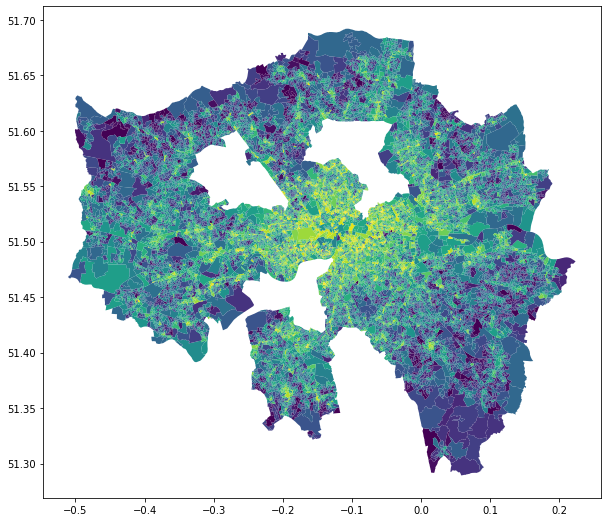

In [13]:
oa_with_tree_stats.plot(column = "walkability_score_m1", figsize = (10, 10))

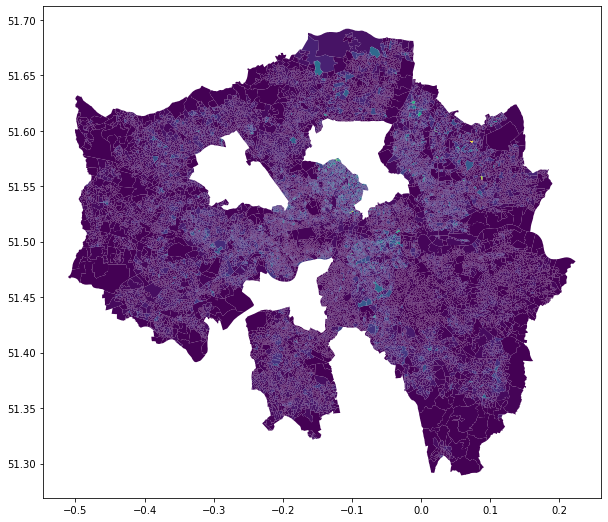

In [14]:
oa_with_tree_stats.plot(column = "trees_per_hectare", figsize = (10, 10))

Text(0, 0.5, 'Walkability Score')

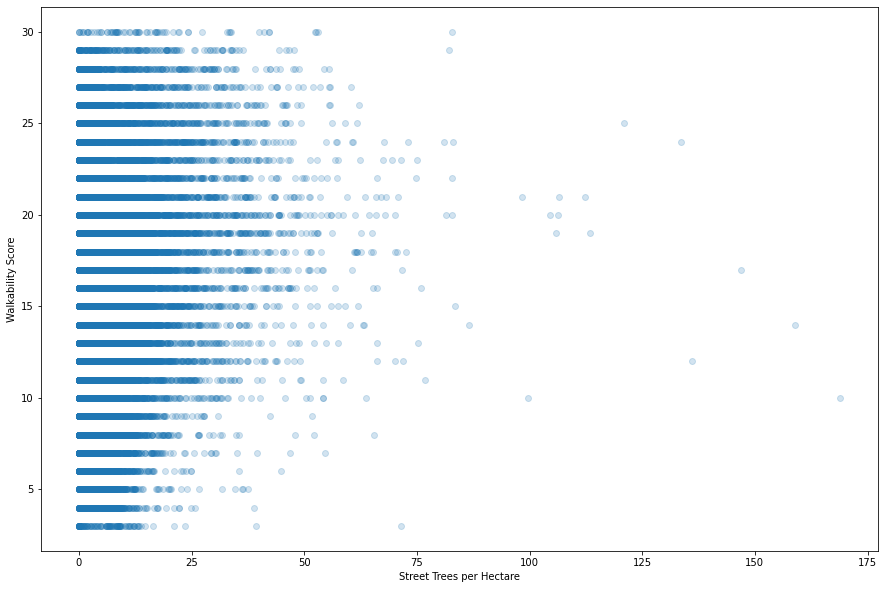

In [15]:
pyplot.figure(figsize = (15, 10))
pyplot.scatter(oa_with_tree_stats["trees_per_hectare"], oa_with_tree_stats["walkability_score_m1"], alpha = 0.2)
pyplot.xlabel("Street Trees per Hectare")
pyplot.ylabel("Walkability Score")

In [16]:
## Try a linear regression (with no expectation of any correlation)
smf.ols(formula = "walkability_score_m1 ~ trees_per_hectare", data = oa_with_tree_stats).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     walkability_score_m1   R-squared:                       0.025
Model:                              OLS   Adj. R-squared:                  0.025
Method:                   Least Squares   F-statistic:                     476.5
Date:                  Tue, 30 Jun 2020   Prob (F-statistic):          2.45e-104
Time:                          17:20:29   Log-Likelihood:                -59830.
No. Observations:                 18644   AIC:                         1.197e+05
Df Residuals:                     18642   BIC:                         1.197e+05
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            15.4681      0.057    270.271      0.000      15.356      15.580
trees_per_hectare     0.0921      0.004     21.830      0.000       0.084       0.100
==============================================================================
Omnibus:                      743.075   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              321.574
Skew:                           0.024   Prob(JB):                     1.48e-70
Kurtosis:                       2.358   Cond. No.                         17.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
## Try clustering

X = oa_with_tree_stats.loc[:, ["residential_density_decile", "partial_walkability_score_m1", "trees_per_hectare_decile"]]
km = KMeans(n_clusters=4, random_state=1)
km.fit(X)

oa_with_tree_stats["cluster"] = km.labels_

km.cluster_centers_

array([[ 5.34204131,  4.21040907,  4.87302552],
       [ 4.88061224, 17.37795918,  5.34632653],
       [ 4.84457781, 10.55960265,  2.5115894 ],
       [ 7.3326623 , 10.63789633,  8.1829391 ]])

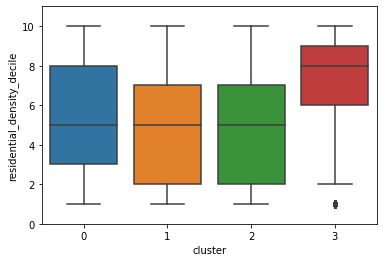

In [33]:
sns.boxplot(y = oa_with_tree_stats["residential_density_decile"], x = oa_with_tree_stats["cluster"], )
pyplot.ylim(0, 11);

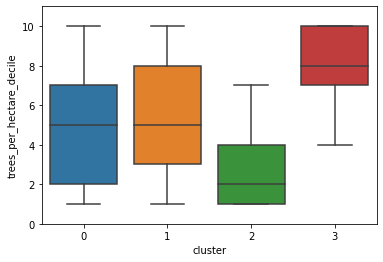

In [34]:
sns.boxplot(y = oa_with_tree_stats["trees_per_hectare_decile"], x = oa_with_tree_stats["cluster"])
pyplot.ylim(0, 11);

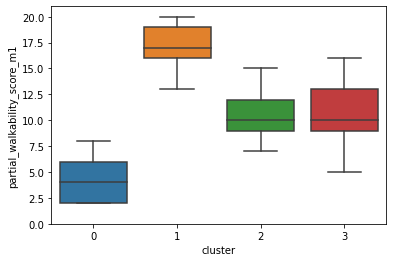

In [36]:
sns.boxplot(y = oa_with_tree_stats["partial_walkability_score_m1"], x = oa_with_tree_stats["cluster"])
pyplot.ylim(0, 21);

In [28]:
## obtain percentages
dwelling_count_by_cluster = oa_with_tree_stats.loc[:, ["cluster", "oa_occupied_household_space_count"]].groupby("cluster").agg("sum")
total_dwellings = sum(dwelling_count_by_cluster["oa_occupied_household_space_count"])
dwelling_count_by_cluster["pct"] = dwelling_count_by_cluster["oa_occupied_household_space_count"].map(lambda x: x / total_dwellings)
dwelling_count_by_cluster

,oa_occupied_household_space_count,pct
cluster,,
0,614772,0.263884
1,608130,0.261033
2,604945,0.259666
3,501856,0.215416


In [37]:
## Output to CSV

oa_with_tree_stats.drop(["geometry"], axis = "columns", inplace = False).to_csv("output.csv")